# Giới thiệu 
__Hệ thống CBIR (truy xuất hình ảnh dựa trên nội dung)__

__Trích xuất đặc trưng của hình ảnh truy vấn và truy xuất các đặc trưng tương tự từ cơ sở dữ liệu hình ảnh__

<img align='center' style="border-color:gray;border-width:2px;border-style:dashed"   src='CBIR.png' padding='5px' height="300px"></img>

# Trích rút đặc trưng:
Trong phần này chúng ta thực hiện các phương pháp trích rút đặc trưng phổ biến:
- color-based
- texture-based
- shape-based

# Hãy thực hiện thay đổi tham số thử nghiệm cho các phương pháp

# 1 Color-Based
## RGB histogram

In [1]:
from __future__ import print_function

from src.evaluate import distance, evaluate_class
from src.DB import Database
from six.moves import cPickle
import numpy as np
import scipy.misc
import itertools
import imageio
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
# Cấu hình histogram
n_bin   = 12        # histogram bins
n_slice = 3         # slice image
h_type  = 'region'  # global or region
d_type  = 'd1'      # distance type
depth   = 3         # retrieved depth, set to None will count the ap for whole database

# Bộ đệm
cache_dir = 'cache'
if not os.path.exists(cache_dir):
  os.makedirs(cache_dir)


In [158]:
class Color(object):

  def histogram(self, input, n_bin=n_bin, type=h_type, n_slice=n_slice, normalize=True):
    ''' count img color histogram
  
      arguments
        input    : a path to a image or a numpy.ndarray
        n_bin    : number of bins for each channel
        type     : 'global' means count the histogram for whole image
                   'region' means count the histogram for regions in images, then concatanate all of them
        n_slice  : work when type equals to 'region', height & width will equally sliced into N slices
        normalize: normalize output histogram
  
      return
        type == 'global'
          a numpy array with size n_bin ** channel
        type == 'region'
          a numpy array with size n_slice * n_slice * (n_bin ** channel)
    '''
    if isinstance(input, np.ndarray):  # examinate input type
      img = input.copy()
    else:
      #img = scipy.misc.imread(input, mode='RGB')
      img = imageio.imread(input)  
    height, width, channel = img.shape
    bins = np.linspace(0, 256, n_bin+1, endpoint=True)  # Cắt các bins bằng nhau cho mỗi kênh
  
    if type == 'global':
      hist = self._count_hist(img, n_bin, bins, channel)
  
    elif type == 'region':
      hist = np.zeros((n_slice, n_slice, n_bin ** channel))
      h_silce = np.around(np.linspace(0, height, n_slice+1, endpoint=True)).astype(int)
      w_slice = np.around(np.linspace(0, width, n_slice+1, endpoint=True)).astype(int)
  
      for hs in range(len(h_silce)-1):
        for ws in range(len(w_slice)-1):
          img_r = img[h_silce[hs]:h_silce[hs+1], w_slice[ws]:w_slice[ws+1]]  # Cắt img thành các vùng
          hist[hs][ws] = self._count_hist(img_r, n_bin, bins, channel)
  
    if normalize:
      hist /= np.sum(hist)
  
    return hist.flatten()
  
  
  def _count_hist(self, input, n_bin, bins, channel):
    img = input.copy()
    bins_idx = {key: idx for idx, key in enumerate(itertools.product(np.arange(n_bin), repeat=channel))}  # permutation of bins
    hist = np.zeros(n_bin ** channel)
  
    # Phân cụm từng pixel
    for idx in range(len(bins)-1):
      img[(input >= bins[idx]) & (input < bins[idx+1])] = idx
    # Thêm các pixel từ bins
    height, width, _ = img.shape
    for h in range(height):
      for w in range(width):
        b_idx = bins_idx[tuple(img[h,w])]
        hist[b_idx] += 1
  
    return hist
  
  
  def make_samples(self, db, verbose=True):
    if h_type == 'global':
      sample_cache = "histogram_cache-{}-n_bin{}".format(h_type, n_bin)
    elif h_type == 'region':
      sample_cache = "histogram_cache-{}-n_bin{}-n_slice{}".format(h_type, n_bin, n_slice)
    
    try:
      samples = cPickle.load(open(os.path.join(cache_dir, sample_cache), "rb", True))
      if verbose:
        print("Using cache..., config=%s, distance=%s, depth=%s" % (sample_cache, d_type, depth))
    except:
      if verbose:
        print("Counting histogram..., config=%s, distance=%s, depth=%s" % (sample_cache, d_type, depth))
      samples = []
      data = db.get_data()
      for d in data.itertuples():
        d_img, d_cls = getattr(d, "img"), getattr(d, "cls")
        d_hist = self.histogram(d_img, type=h_type, n_bin=n_bin, n_slice=n_slice)
        samples.append({
                        'img':  d_img, 
                        'cls':  d_cls, 
                        'hist': d_hist
                      })
      cPickle.dump(samples, open(os.path.join(cache_dir, sample_cache), "wb", True))
  
    return samples

### Đọc dữ liệu và tạo ra file data.csv
Xóa file data.csv trước khi chạy

In [159]:
db = Database()
data = db.get_data()

In [160]:
color = Color()

# test normalize
hist = color.histogram(data.iloc[0,0], type='global')
assert hist.sum() - 1 < 1e-9, "normalize false"

In [3]:
# Kiểm tra histogram bins
def sigmoid(z):
    a = 1.0 / (1.0 + np.exp(-1. * z))
    return a
np.random.seed(0)
IMG = sigmoid(np.random.randn(2,2,3)) * 255
IMG = IMG.astype(int)
hist = color.histogram(IMG, type='global', n_bin=4)
assert np.equal(np.where(hist > 0)[0], np.array([37, 43, 58, 61])).all(), "global histogram implement failed"
hist = color.histogram(IMG, type='region', n_bin=4, n_slice=2)
assert np.equal(np.where(hist > 0)[0], np.array([58, 125, 165, 235])).all(), "region histogram implement failed"

# Ước lượng khoảng cách
np.random.seed(1)
IMG = sigmoid(np.random.randn(4,4,3)) * 255
IMG = IMG.astype(int)
hist = color.histogram(IMG, type='region', n_bin=4, n_slice=2)
IMG2 = sigmoid(np.random.randn(4,4,3)) * 255
IMG2 = IMG2.astype(int)
hist2 = color.histogram(IMG2, type='region', n_bin=4, n_slice=2)
assert distance(hist, hist2, d_type='d1') == 2, "d1 implement failed"
assert distance(hist, hist2, d_type='d2-norm') == 2, "d2 implement failed"

# Đánh giá CSDL
APs = evaluate_class(db, f_class=Color, d_type=d_type, depth=depth)
cls_MAPs = []
for cls, cls_APs in APs.items():
    MAP = np.mean(cls_APs)
    print("Class {}, MAP {}".format(cls, MAP))
    cls_MAPs.append(MAP)
print("MMAP", np.mean(cls_MAPs))

# 2. texture-based
## Bộ lọc gabor

In [58]:
from __future__ import print_function

from src.evaluate import *
from src.DB import Database

from skimage.filters import gabor_kernel
from skimage import color
from scipy import ndimage as ndi

import multiprocessing

from six.moves import cPickle
import numpy as np
import scipy.misc
import os

In [4]:
theta     = 4
frequency = (0.1, 0.5, 0.8)
sigma     = (1, 3, 5)
bandwidth = (0.3, 0.7, 1)

n_slice  = 2
h_type   = 'global'
d_type   = 'cosine'

depth    = 1


In [60]:
def make_gabor_kernel(theta, frequency, sigma, bandwidth):
  kernels = []
  for t in range(theta):
    t = t / float(theta) * np.pi
    for f in frequency:
      if sigma:
        for s in sigma:
          kernel = gabor_kernel(f, theta=t, sigma_x=s, sigma_y=s)
          kernels.append(kernel)
      if bandwidth:
        for b in bandwidth:
          kernel = gabor_kernel(f, theta=t, bandwidth=b)
          kernels.append(kernel)
  return kernels

In [61]:
gabor_kernels = make_gabor_kernel(theta, frequency, sigma, bandwidth)
if sigma and not bandwidth:
  assert len(gabor_kernels) == theta * len(frequency) * len(sigma), "kernel nums error in make_gabor_kernel()"
elif not sigma and bandwidth:
  assert len(gabor_kernels) == theta * len(frequency) * len(bandwidth), "kernel nums error in make_gabor_kernel()"
elif sigma and bandwidth:
  assert len(gabor_kernels) == theta * len(frequency) * (len(sigma) + len(bandwidth)), "kernel nums error in make_gabor_kernel()"
elif not sigma and not bandwidth:
  assert len(gabor_kernels) == theta * len(frequency), "kernel nums error in make_gabor_kernel()"

# cache dir
cache_dir = 'cache'
if not os.path.exists(cache_dir):
  os.makedirs(cache_dir)

In [62]:
class Gabor(object):  
  
  def gabor_histogram(self, input, type=h_type, n_slice=n_slice, normalize=True):
    ''' count img histogram
  
      arguments
        input    : a path to a image or a numpy.ndarray
        type     : 'global' means count the histogram for whole image
                   'region' means count the histogram for regions in images, then concatanate all of them
        n_slice  : work when type equals to 'region', height & width will equally sliced into N slices
        normalize: normalize output histogram
  
      return
        type == 'global'
          a numpy array with size len(gabor_kernels)
        type == 'region'
          a numpy array with size len(gabor_kernels) * n_slice * n_slice
    '''
    if isinstance(input, np.ndarray):  # examinate input type
      img = input.copy()
    else:
      #img = scipy.misc.imread(input, mode='RGB')
      img=imageio.imread(input)
    height, width, channel = img.shape
  
    if type == 'global':
      hist = self._gabor(img, kernels=gabor_kernels)
  
    elif type == 'region':
      hist = np.zeros((n_slice, n_slice, len(gabor_kernels)))
      h_silce = np.around(np.linspace(0, height, n_slice+1, endpoint=True)).astype(int)
      w_slice = np.around(np.linspace(0, width, n_slice+1, endpoint=True)).astype(int)
  
      for hs in range(len(h_silce)-1):
        for ws in range(len(w_slice)-1):
          img_r = img[h_silce[hs]:h_silce[hs+1], w_slice[ws]:w_slice[ws+1]]  # slice img to regions
          hist[hs][ws] = self._gabor(img_r, kernels=gabor_kernels)
  
    if normalize:
      hist /= np.sum(hist)
  
    return hist.flatten()
  
  
  def _feats(self, image, kernel):
    '''
      arguments
        image : ndarray of the image
        kernel: a gabor kernel
      return
        a ndarray whose shape is (2, )
    '''
    feats = np.zeros(2, dtype=np.double)
    filtered = ndi.convolve(image, np.real(kernel), mode='wrap')
    feats[0] = filtered.mean()
    feats[1] = filtered.var()
    return feats
  
  
  def _power(self, image, kernel):
    '''
      arguments
        image : ndarray of the image
        kernel: a gabor kernel
      return
        a ndarray whose shape is (2, )
    '''
    image = (image - image.mean()) / image.std()  # Normalize images for better comparison.
    f_img = np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)
    feats = np.zeros(2, dtype=np.double)
    feats[0] = f_img.mean()
    feats[1] = f_img.var()
    return feats
  
  
  def _gabor(self, image, kernels=make_gabor_kernel(theta, frequency, sigma, bandwidth), normalize=True):
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
  
    img = color.rgb2gray(image)
  
    results = []
    feat_fn = self._power
    for kernel in kernels:
      results.append(pool.apply_async(self._worker, (img, kernel, feat_fn)))
    pool.close()
    pool.join()
    
    hist = np.array([res.get() for res in results])
  
    if normalize:
      hist = hist / np.sum(hist, axis=0)
  
    return hist.T.flatten()
  
  
  def _worker(self, img, kernel, feat_fn):
    try:
      ret = feat_fn(img, kernel)
    except:
      print("return zero")
      ret = np.zeros(2)
    return ret
  
  
  def make_samples(self, db, verbose=True):
    if h_type == 'global':
      sample_cache = "gabor-{}-theta{}-frequency{}-sigma{}-bandwidth{}".format(h_type, theta, frequency, sigma, bandwidth)
    elif h_type == 'region':
      sample_cache = "gabor-{}-n_slice{}-theta{}-frequency{}-sigma{}-bandwidth{}".format(h_type, n_slice, theta, frequency, sigma, bandwidth)
  
    try:
      samples = cPickle.load(open(os.path.join(cache_dir, sample_cache), "rb", True))
      for sample in samples:
        sample['hist'] /= np.sum(sample['hist'])  # normalize
      if verbose:
        print("Using cache..., config=%s, distance=%s, depth=%s" % (sample_cache, d_type, depth))
    except:
      if verbose:
        print("Counting histogram..., config=%s, distance=%s, depth=%s" % (sample_cache, d_type, depth))
  
      samples = []
      data = db.get_data()
      for d in data.itertuples():
        d_img, d_cls = getattr(d, "img"), getattr(d, "cls")
        d_hist = self.gabor_histogram(d_img, type=h_type, n_slice=n_slice)
        samples.append({
                        'img':  d_img, 
                        'cls':  d_cls, 
                        'hist': d_hist
                      })
      cPickle.dump(samples, open(os.path.join(cache_dir, sample_cache), "wb", True))
  
    return samples


In [64]:
db = Database()

# evaluate database
APs = evaluate_class(db, f_class=Gabor, d_type=d_type, depth=depth)
cls_MAPs = []
for cls, cls_APs in APs.items():
    MAP = np.mean(cls_APs)
    print("Class {}, MAP {}".format(cls, MAP))
    cls_MAPs.append(MAP)
print("MMAP", np.mean(cls_MAPs))

# shape-based
 - [edge histogram]
 - [HOG (histogram of gradient)]

# Edge histogram

In [69]:
from __future__ import print_function

from src.evaluate import evaluate_class
from src.DB import Database

from six.moves import cPickle
import numpy as np
import scipy.misc
from math import sqrt
import os

In [70]:
stride = (1, 1)
n_slice  = 10
h_type   = 'region'
d_type   = 'cosine'

depth    = 5

edge_kernels = np.array([
  [
   # vertical
   [1,-1], 
   [1,-1]
  ],
  [
   # horizontal
   [1,1], 
   [-1,-1]
  ],
  [
   # 45 diagonal
   [sqrt(2),0], 
   [0,-sqrt(2)]
  ],
  [
   # 135 diagnol
   [0,sqrt(2)], 
   [-sqrt(2),0]
  ],
  [
   # non-directional
   [2,-2], 
   [-2,2]
  ]
])

# cache dir
cache_dir = 'cache'
if not os.path.exists(cache_dir):
  os.makedirs(cache_dir)

In [71]:
class Edge(object):

  def histogram(self, input, stride=(2, 2), type=h_type, n_slice=n_slice, normalize=True):
    ''' count img histogram
  
      arguments
        input    : a path to a image or a numpy.ndarray
        stride   : stride of edge kernel
        type     : 'global' means count the histogram for whole image
                   'region' means count the histogram for regions in images, then concatanate all of them
        n_slice  : work when type equals to 'region', height & width will equally sliced into N slices
        normalize: normalize output histogram
  
      return
        type == 'global'
          a numpy array with size len(edge_kernels)
        type == 'region'
          a numpy array with size len(edge_kernels) * n_slice * n_slice
    '''
    if isinstance(input, np.ndarray):  # examinate input type
      img = input.copy()
    else:
      img = imageio.imread(input)
    height, width, channel = img.shape
  
    if type == 'global':
      hist = self._conv(img, stride=stride, kernels=edge_kernels)
  
    elif type == 'region':
      hist = np.zeros((n_slice, n_slice, edge_kernels.shape[0]))
      h_silce = np.around(np.linspace(0, height, n_slice+1, endpoint=True)).astype(int)
      w_slice = np.around(np.linspace(0, width, n_slice+1, endpoint=True)).astype(int)
  
      for hs in range(len(h_silce)-1):
        for ws in range(len(w_slice)-1):
          img_r = img[h_silce[hs]:h_silce[hs+1], w_slice[ws]:w_slice[ws+1]]  # slice img to regions
          hist[hs][ws] = self._conv(img_r, stride=stride, kernels=edge_kernels)
  
    if normalize:
      hist /= np.sum(hist)
  
    return hist.flatten()
  
  
  def _conv(self, img, stride, kernels, normalize=True):
    H, W, C = img.shape
    conv_kernels = np.expand_dims(kernels, axis=3)
    conv_kernels = np.tile(conv_kernels, (1, 1, 1, C))
    assert list(conv_kernels.shape) == list(kernels.shape) + [C]  # check kernels size
  
    sh, sw = stride
    kn, kh, kw, kc = conv_kernels.shape
  
    hh = int((H - kh) / sh + 1)
    ww = int((W - kw) / sw + 1)
  
    hist = np.zeros(kn)
  
    for idx, k in enumerate(conv_kernels):
      for h in range(hh):
        hs = int(h*sh)
        he = int(h*sh + kh)
        for w in range(ww):
          ws = w*sw
          we = w*sw + kw
          hist[idx] += np.sum(img[hs:he, ws:we] * k)  # element-wise product
  
    if normalize:
      hist /= np.sum(hist)
  
    return hist
  
  
  def make_samples(self, db, verbose=True):
    if h_type == 'global':
      sample_cache = "edge-{}-stride{}".format(h_type, stride)
    elif h_type == 'region':
      sample_cache = "edge-{}-stride{}-n_slice{}".format(h_type, stride, n_slice)
  
    try:
      samples = cPickle.load(open(os.path.join(cache_dir, sample_cache), "rb", True))
      for sample in samples:
        sample['hist'] /= np.sum(sample['hist'])  # normalize
      if verbose:
        print("Using cache..., config=%s, distance=%s, depth=%s" % (sample_cache, d_type, depth))
    except:
      if verbose:
        print("Counting histogram..., config=%s, distance=%s, depth=%s" % (sample_cache, d_type, depth))
  
      samples = []
      data = db.get_data()
      for d in data.itertuples():
        d_img, d_cls = getattr(d, "img"), getattr(d, "cls")
        d_hist = self.histogram(d_img, type=h_type, n_slice=n_slice)
        samples.append({
                        'img':  d_img, 
                        'cls':  d_cls, 
                        'hist': d_hist
                      })
      cPickle.dump(samples, open(os.path.join(cache_dir, sample_cache), "wb", True))
  
    return samples

In [5]:
db = Database()

# check shape
assert edge_kernels.shape == (5, 2, 2)

  # evaluate database
APs = evaluate_class(db, f_class=Edge, d_type=d_type, depth=depth)
cls_MAPs = []
for cls, cls_APs in APs.items():
    MAP = np.mean(cls_APs)
    print("Class {}, MAP {}".format(cls, MAP))
    cls_MAPs.append(MAP)
print("MMAP", np.mean(cls_MAPs))

# HOG (histogram of gradient)

In [165]:
from __future__ import print_function

from src.evaluate import evaluate_class
from src.DB import Database

from skimage.feature import hog
from skimage import color

from six.moves import cPickle
import numpy as np
import scipy.misc
import os

In [166]:
n_bin    = 10
n_slice  = 6
n_orient = 8
p_p_c    = (2, 2)
c_p_b    = (1, 1)
h_type   = 'region'
d_type   = 'd1'

depth    = 5

# cache dir
cache_dir = 'cache'
if not os.path.exists(cache_dir):
  os.makedirs(cache_dir)

In [167]:
class HOG(object):

  def histogram(self, input, n_bin=n_bin, type=h_type, n_slice=n_slice, normalize=True):
    ''' count img histogram
  
      arguments
        input    : a path to a image or a numpy.ndarray
        n_bin    : number of bins of histogram
        type     : 'global' means count the histogram for whole image
                   'region' means count the histogram for regions in images, then concatanate all of them
        n_slice  : work when type equals to 'region', height & width will equally sliced into N slices
        normalize: normalize output histogram
  
      return
        type == 'global'
          a numpy array with size n_bin
        type == 'region'
          a numpy array with size n_bin * n_slice * n_slice
    '''
    if isinstance(input, np.ndarray):  # examinate input type
      img = input.copy()
    else:
      img = imageio.imread(input)
    height, width, channel = img.shape
  
    if type == 'global':
      hist = self._HOG(img, n_bin)
  
    elif type == 'region':
      hist = np.zeros((n_slice, n_slice, n_bin))
      h_silce = np.around(np.linspace(0, height, n_slice+1, endpoint=True)).astype(int)
      w_slice = np.around(np.linspace(0, width, n_slice+1, endpoint=True)).astype(int)
  
      for hs in range(len(h_silce)-1):
        for ws in range(len(w_slice)-1):
          img_r = img[h_silce[hs]:h_silce[hs+1], w_slice[ws]:w_slice[ws+1]]  # slice img to regions
          hist[hs][ws] = self._HOG(img_r, n_bin)
  
    if normalize:
      hist /= np.sum(hist)
  
    return hist.flatten()

  def _HOG(self, img, n_bin, normalize=True):
    image = color.rgb2gray(img)
    fd = hog(image, orientations=n_orient, pixels_per_cell=p_p_c, cells_per_block=c_p_b)
    bins = np.linspace(0, np.max(fd), n_bin+1, endpoint=True)
    hist, _ = np.histogram(fd, bins=bins)
  
    if normalize:
      hist = np.array(hist) / np.sum(hist)
  
    return hist

  def make_samples(self, db, verbose=True):
    if h_type == 'global':
      sample_cache = "HOG-{}-n_bin{}-n_orient{}-ppc{}-cpb{}".format(h_type, n_bin, n_orient, p_p_c, c_p_b)
    elif h_type == 'region':
      sample_cache = "HOG-{}-n_bin{}-n_slice{}-n_orient{}-ppc{}-cpb{}".format(h_type, n_bin, n_slice, n_orient, p_p_c, c_p_b)
  
    try:
      samples = cPickle.load(open(os.path.join(cache_dir, sample_cache), "rb", True))
      for sample in samples:
        sample['hist'] /= np.sum(sample['hist'])  # normalize
      if verbose:
        print("Using cache..., config=%s, distance=%s, depth=%s" % (sample_cache, d_type, depth))
    except:
      if verbose:
        print("Counting histogram..., config=%s, distance=%s, depth=%s" % (sample_cache, d_type, depth))

      samples = []
      data = db.get_data()
      for d in data.itertuples():
        d_img, d_cls = getattr(d, "img"), getattr(d, "cls")
        d_hist = self.histogram(d_img, type=h_type, n_slice=n_slice)
        samples.append({
                        'img':  d_img, 
                        'cls':  d_cls, 
                        'hist': d_hist
                      })
      cPickle.dump(samples, open(os.path.join(cache_dir, sample_cache), "wb", True))

    return samples

In [6]:
db = Database()
# evaluate database
APs = evaluate_class(db, f_class=HOG, d_type=d_type, depth=depth)
cls_MAPs = []
for cls, cls_APs in APs.items():
    MAP = np.mean(cls_APs)
    print("Class {}, MAP {}".format(cls, MAP))
    cls_MAPs.append(MAP)
print("MMAP", np.mean(cls_MAPs))

# Tìm kiếm hình ảnh cụ thể và hiển thị kết quả

In [161]:
depth = 3
query_idx = 0

In [162]:
from src.evaluate import infer
db = Database()
# retrieve by color
method = color
samples = method.make_samples(db)
d_type = 'd1'

Using cache..., config=histogram_cache-region-n_bin12-n_slice3, distance=d1, depth=3


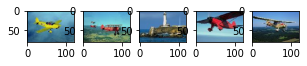

In [170]:
link_img="database/obj_aviation/360005.jpg"
img=method.histogram(link_img)
query={'img':'','cls':'','hist':img}
_, result = infer(query, samples=samples, depth=5, d_type=d_type)
img_show = cv2.imread(link_img)
img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(20, 20))
count=0
for i in result:
    link=i['link']
    img_show = cv2.imread(link)
    img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    count+=1
    fig.add_subplot(20, 20, count)
    plt.imshow(img_show)
plt.show()

[{'dis': 0.0, 'cls': 'obj_aviation', 'link': 'database/obj_aviation/360005.jpg'}, {'dis': 0.159292328042328, 'cls': 'art_mural', 'link': 'database/art_mural/554007.jpg'}, {'dis': 0.1701719576719577, 'cls': 'obj_bus', 'link': 'database/obj_bus/581001.jpg'}, {'dis': 0.1726025132275132, 'cls': 'art_mural', 'link': 'database/art_mural/554003.jpg'}, {'dis': 0.17333002645502643, 'cls': 'obj_bus', 'link': 'database/obj_bus/581004.jpg'}]


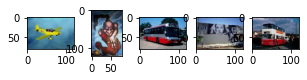

In [171]:
link_img="database/obj_aviation/360005.jpg"
hog1=HOG()
samples_hog = hog1.make_samples(db)
d_type = 'd1'
img=hog1.histogram(input=link_img)
query={'img':'','cls':'','hist':img}
_, result = infer(query, samples=samples_hog, depth=5, d_type=d_type)
img_show = cv2.imread(link_img)
img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(20, 20))
count=0
print(result)
for i in result:
    link=i['link']
    img_show = cv2.imread(link)
    img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    count+=1
    fig.add_subplot(20, 20, count)
    plt.imshow(img_show)
plt.show()

# Using sift for CBIR

In [201]:
cache_dir = 'cache'
if not os.path.exists(cache_dir):
  os.makedirs(cache_dir)

class SIFT(object):
  def extract_feature(self, input):
    img= cv2.imread(input)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img,None)
    return des
  
  def make_samples(self, db, verbose=True):
    sample_cache = "sift_cache"
    try:
      samples = cPickle.load(open(os.path.join(cache_dir, sample_cache), "rb", True))
      if verbose:
        print("Using cache..., " )
    except:
      if verbose:
        print("Counting histogram..." )
      samples = []
      data = db.get_data()
      for d in data.itertuples():
        d_img, d_cls = getattr(d, "img"), getattr(d, "cls")
        d_hist = self.extract_feature(d_img)
        samples.append({
                        'img':  d_img, 
                        'cls':  d_cls, 
                        'hist': d_hist
                      })
      cPickle.dump(samples, open(os.path.join(cache_dir, sample_cache), "wb", True))
  
    return samples

In [202]:
def infer_cbir(query, samples=None, db=None, sample_db_fn=None, depth=None, d_type='d1'):
  assert samples != None or (db != None and sample_db_fn != None), "need to give either samples or db plus sample_db_fn"
  FLANN_INDEX_KDTREE = 0
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params,search_params)
  #samples = sample_db_fn(db)
  q_img, q_cls, q_hist = query['img'], query['cls'], query['hist']
  results = []
  for idx, sample in enumerate(samples):
    s_img, s_cls, s_hist = sample['img'], sample['cls'], sample['hist']
    if q_img == s_img:
      continue
    matches2 = flann.knnMatch(q_hist,s_hist,k=2)
    matches = []
    for m,n in matches2:
        # giữ lại các cặp keypoint sao cho với kp1, khoảng cách giữa kp1 với ứng viên 1 nhỏ hơn nhiều so với khoảng cách giữa kp1 và ứng viên 2
        if m.distance < n.distance * 1:
            matches.append(m)
    matches = sorted(matches, key=lambda x: x.distance, reverse=True)
    sum=0
    for i in range(len(matches)):
        sum=sum+matches[i].distance
    sum=sum/len(matches)
    
    results.append({
                    'dis': sum,
                    'cls': s_cls
                  })
  results = sorted(results, key=lambda x: x['dis'])
  if depth and depth <= len(results):
    results = results[:depth]
  #ap = AP(q_cls, results, sort=False)

  return result

Using cache..., 
[{'dis': 0.0, 'cls': 'obj_aviation', 'link': 'database/obj_aviation/360005.jpg'}, {'dis': 0.159292328042328, 'cls': 'art_mural', 'link': 'database/art_mural/554007.jpg'}, {'dis': 0.1701719576719577, 'cls': 'obj_bus', 'link': 'database/obj_bus/581001.jpg'}, {'dis': 0.1726025132275132, 'cls': 'art_mural', 'link': 'database/art_mural/554003.jpg'}, {'dis': 0.17333002645502643, 'cls': 'obj_bus', 'link': 'database/obj_bus/581004.jpg'}]


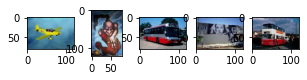

In [203]:

sift=SIFT()
samples_sift = sift.make_samples(db)
link_img="database/obj_aviation/360005.jpg"
img = sift.extract_feature(link_img)
query={'img':'','cls':'','hist':img}
result = infer_cbir(query, samples=samples_sift,db=db,depth=5)
img_show = cv2.imread(link_img)
img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(20, 20))
count=0
print(result)
for i in result:
    link=i['link']
    img_show = cv2.imread(link)
    img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    count+=1
    fig.add_subplot(20, 20, count)
    plt.imshow(img_show)
plt.show()

# Tìm hiểu và thực hiện kết hợp các đặc trưng để thu được kết quả tốt hơn